In [151]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [152]:
data = pd.read_csv("Tesla - Deaths.csv") # load the data

In [153]:
data.head() # top 5 rows of the dataset

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...,NaN,NaN,NaN,NaN,NaN
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...,NaN,Taren Singh Lal,NaN,NaN,NaN
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230107232745/ht...,NaN,NaN,NaN,NaN,NaN
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,NaN,NaN,NaN,NaN,NaN
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,...,-,-,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,NaN,NaN,NaN,NaN,NaN


#### Perform preliminary data inspection checking for data types, missing values, duplicates.

In [154]:
missing_values = data.isna() # fetching the missing values

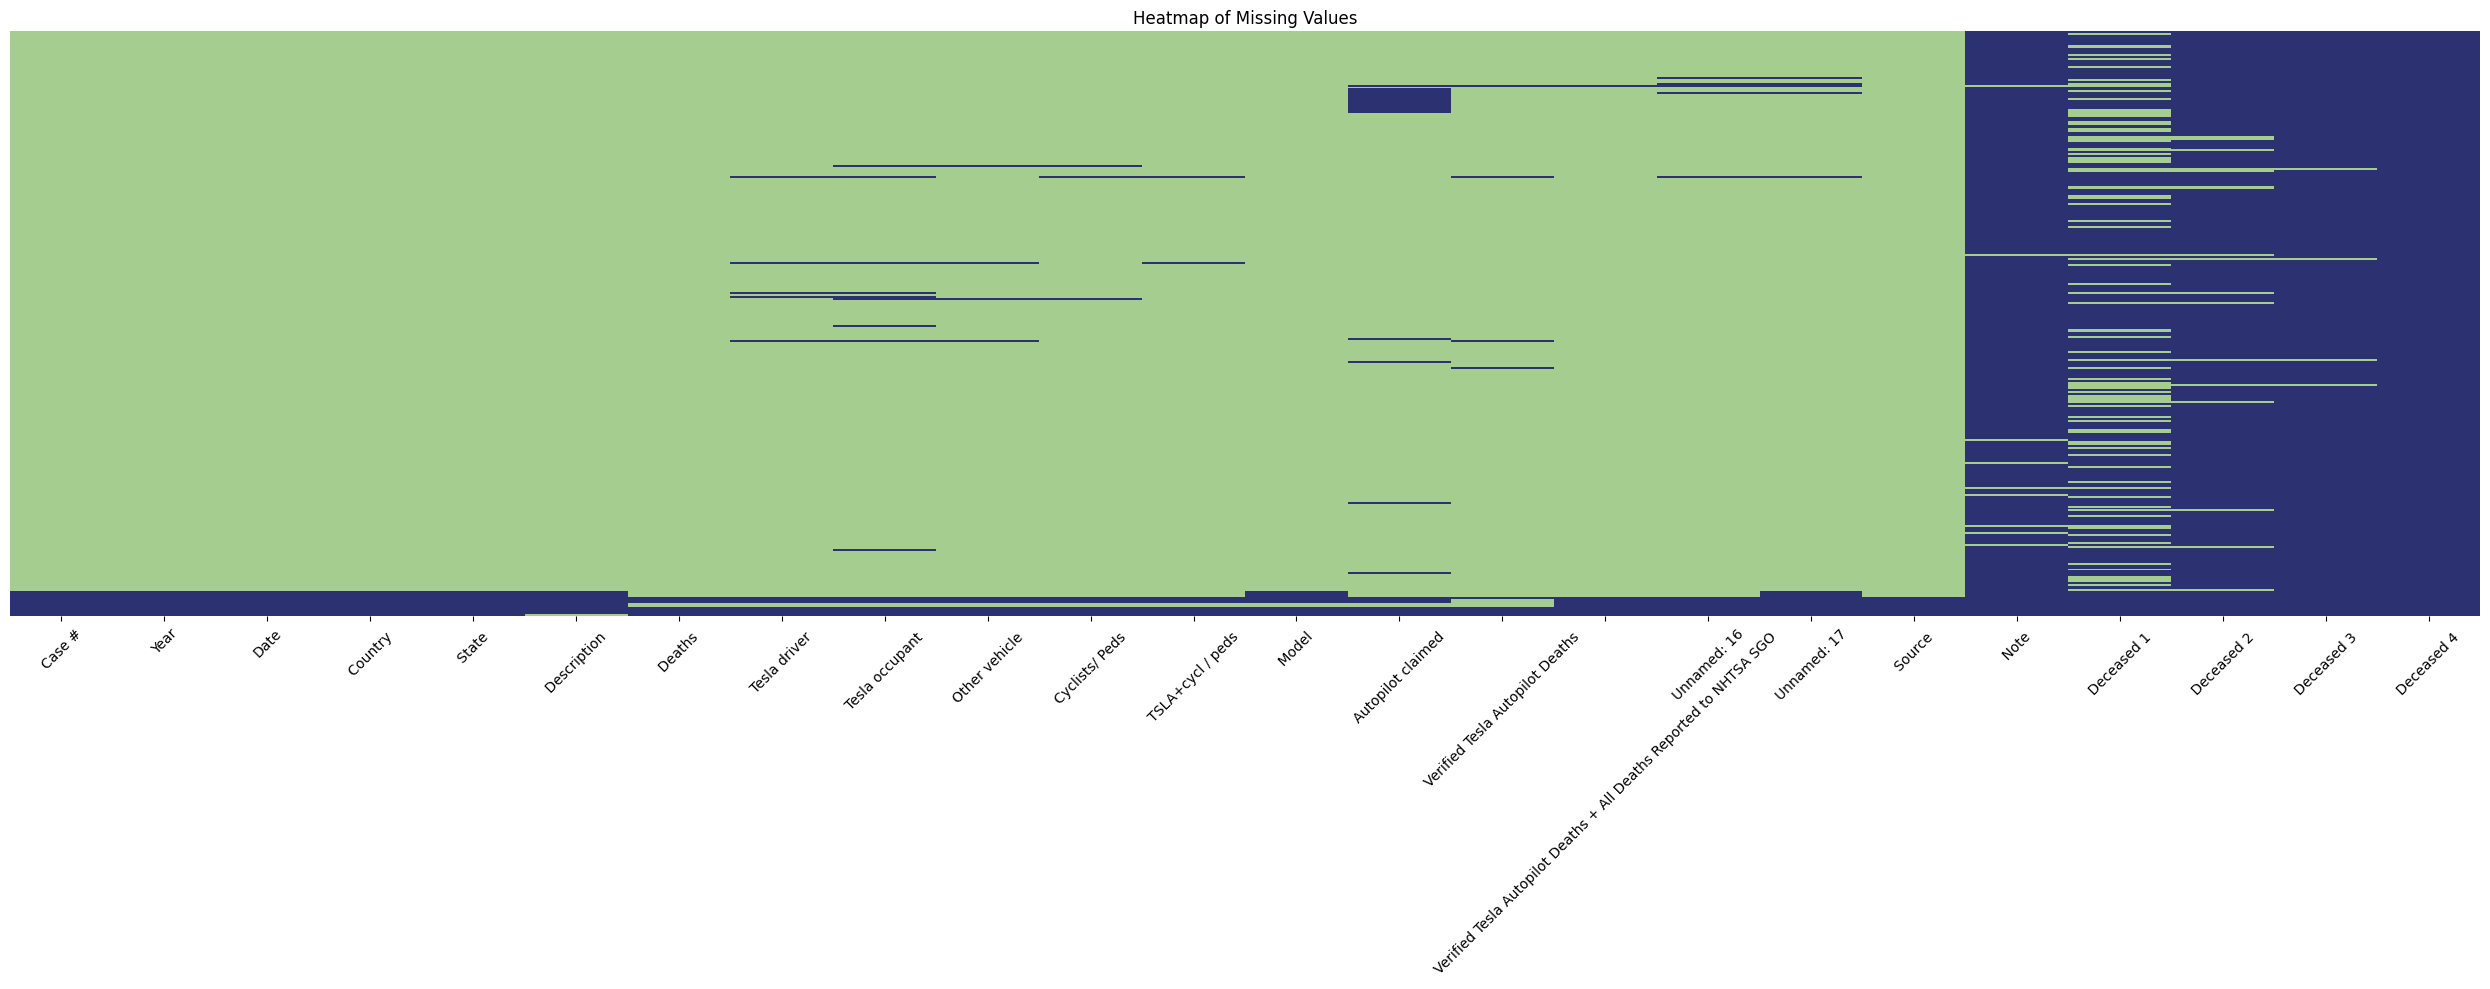

In [155]:
# Heatmap of missing values
fig, ax = plt.subplots(figsize=(25, 10))

# Create the heatmap on the specific 'ax'
sns.heatmap(
    missing_values,
    cmap="crest",
    cbar=False,
    ax=ax,
    )


ax.tick_params(left=False, labelleft=False)
for item in ax.get_xticklabels():
    item.set_rotation(45)

ax.set_title("Heatmap of Missing Values")

plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()


#### Remove any columns which might not be relevant for the analysis.


In [156]:
data.isna().sum() # Sum of null values across columns

,0
Case #,13
Year,13
Date,13
Country,13
State,13
Description,12
Deaths,8
Tesla driver,13
Tesla occupant,17
Other vehicle,12


In [157]:
data.columns

Index(['Case #', 'Year', 'Date', ' Country ', ' State ', ' Description ',
       ' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ',
       'Unnamed: 16', 'Unnamed: 17', ' Source ', ' Note ', ' Deceased 1 ',
       ' Deceased 2 ', ' Deceased 3 ', ' Deceased 4 '],
      dtype='object')

Following columns are not needed -
Unnamed: 16 & Unnamed: 17 contain web link which is not useful

Source : contains web link

Note : contains additional info

Deceased 1 2 3 and 4 contain name of the deceased which is irrelevant to the analysis.

Case# not required

Year can be derived from date

In [158]:
drop_columns = ['Case #','Year', 'Unnamed: 16', 'Unnamed: 17', ' Source ', ' Note ', ' Deceased 1 ',
       ' Deceased 2 ', ' Deceased 3 ', ' Deceased 4 ']
data.drop(columns = drop_columns, inplace = True) # Dropping columns from dataframe

In [159]:
data[' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '].value_counts(dropna = False) # Count of deaths

,count
Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,
-,269
1,21
NaN,11
2,3
3,1
24,1
27,1


On closer analysis we find that variable *' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '*  also contain mostly '-' which represent empty or missing hence we remove this column also

In [160]:
data.drop(columns = ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ', inplace = True)

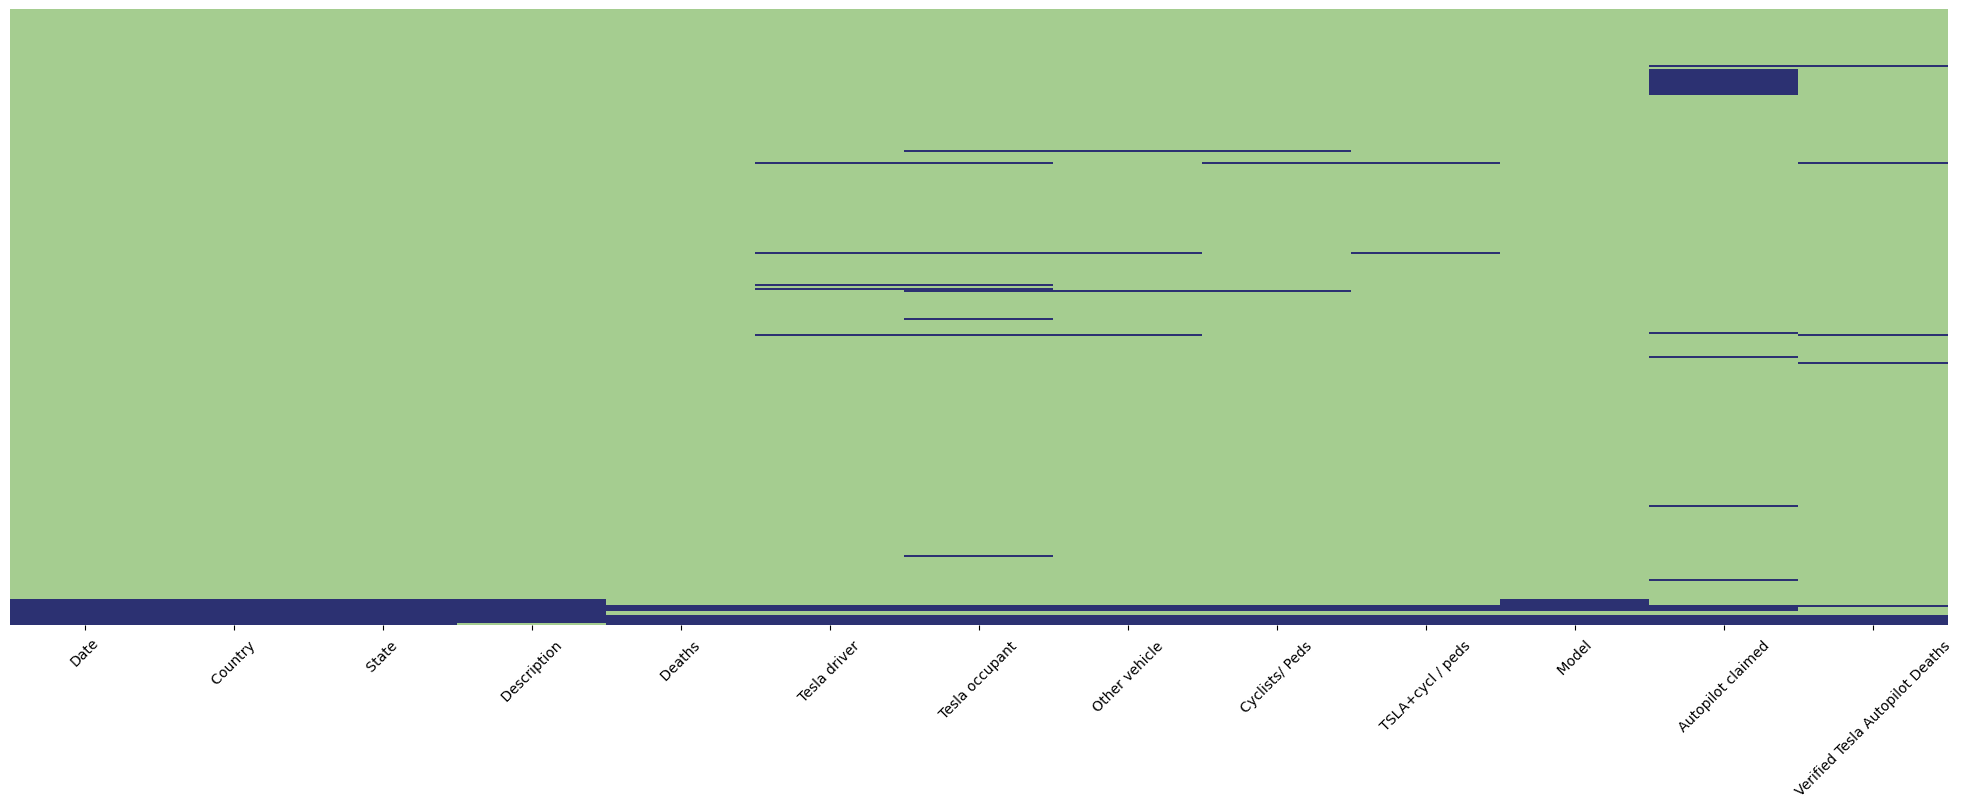

In [161]:
missing_values = data.isna()
plt.figure(figsize = (25,8))
sns.heatmap(missing_values, cmap = "crest", cbar=False)
plt.tick_params( left = False,labelleft = False)
plt.xticks(rotation = 45)
plt.show() # Heatmap of missing values after dropping some columns

## We still have missing so we will impute

Missing values may be in other forms also like in this data they are in "-"

In [162]:
data.head()

,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths
0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,-,1,-,-,-
1,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,-,1,-,-,-
2,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,-,1,-,-,-
3,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,-,1,-,-,-
4,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,1,1,-,-,-


For numerical columns replace "-" with 0 and others with their respective numbers

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               294 non-null    object 
 1    Country                           294 non-null    object 
 2    State                             294 non-null    object 
 3    Description                       295 non-null    object 
 4    Deaths                            299 non-null    float64
 5    Tesla driver                      294 non-null    object 
 6    Tesla occupant                    290 non-null    object 
 7    Other vehicle                     295 non-null    object 
 8    Cyclists/ Peds                    296 non-null    object 
 9    TSLA+cycl / peds                  297 non-null    object 
 10   Model                             296 non-null    object 
 11   Autopilot claimed                 281 non-null    object 

In [164]:
data.columns

Index(['Date', ' Country ', ' State ', ' Description ', ' Deaths ',
       ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths '],
      dtype='object')

In [165]:
cols = data.columns[5:]
for col in cols:
  if col != ' Model ':
    print(col)
    data[col] = data[col].fillna("-")
    data[col] = data[col].str.strip()
    data[col] = data[col].replace("-", "0")
    data[col] = data[col].astype(int)
    print(data[col].unique())

 Tesla driver 
[   1    0   28   89  117    6 2014]
 Tesla occupant 
[   0    1    3    2    7   41   48    5 2015]
 Other vehicle 
[   0    1    2    3    4   29  101  130   16 2016]
 Cyclists/ Peds 
[   0    1    2   20   26   46   11 2017]
 TSLA+cycl / peds 
[   1    0    2    3    4   61  149  210   21 2018]
 Autopilot claimed 
[   0    1    2    8   30   38   47 2020]
 Verified Tesla Autopilot Deaths 
[   0    1    2    3   16   19  118 2022   75 2021]


In [166]:
data.isna().sum()

,0
Date,13
Country,13
State,13
Description,12
Deaths,8
Tesla driver,0
Tesla occupant,0
Other vehicle,0
Cyclists/ Peds,0
TSLA+cycl / peds,0


In [167]:
data.dropna(inplace = True)

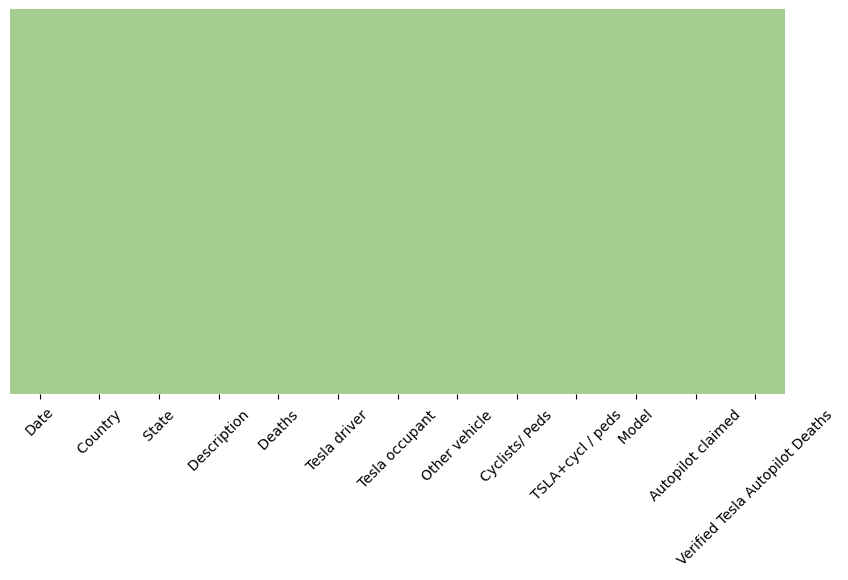

In [168]:
missing_values = data.isna()
plt.figure(figsize = (10,5))
sns.heatmap(missing_values, cmap = "crest", cbar=False)
plt.tick_params( left = False,labelleft = False)
plt.xticks(rotation = 45)
plt.show() # No missing values now

# Change the variable names in accordance to the python norms

In [169]:
data.columns = data.columns.str.strip()
data.columns

Index(['Date', 'Country', 'State', 'Description', 'Deaths', 'Tesla driver',
       'Tesla occupant', 'Other vehicle', 'Cyclists/ Peds', 'TSLA+cycl / peds',
       'Model', 'Autopilot claimed', 'Verified Tesla Autopilot Deaths'],
      dtype='object')

In [170]:
data.columns = data.columns.str.replace(" ", "", regex = True).str.replace("[+/]","_",regex = True)

In [171]:
data.columns

Index(['Date', 'Country', 'State', 'Description', 'Deaths', 'Tesladriver',
       'Teslaoccupant', 'Othervehicle', 'Cyclists_Peds', 'TSLA_cycl_peds',
       'Model', 'Autopilotclaimed', 'VerifiedTeslaAutopilotDeaths'],
      dtype='object')

In [172]:
data.rename(columns = {"Autopilotclaimed":"Claimed", "VerifiedTeslaAutopilotDeaths":"VTAD",
                       "Teslaoccupant" : "Tesla_Occupant", "Othervehicle":'Other_Vehicle',
                       "Tesladriver": "Tesla_Driver"}, inplace = True)

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 0 to 293
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            294 non-null    object 
 1   Country         294 non-null    object 
 2   State           294 non-null    object 
 3   Description     294 non-null    object 
 4   Deaths          294 non-null    float64
 5   Tesla_Driver    294 non-null    int64  
 6   Tesla_Occupant  294 non-null    int64  
 7   Other_Vehicle   294 non-null    int64  
 8   Cyclists_Peds   294 non-null    int64  
 9   TSLA_cycl_peds  294 non-null    int64  
 10  Model           294 non-null    object 
 11  Claimed         294 non-null    int64  
 12  VTAD            294 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 32.2+ KB



# Exploratory Data Analysis



## Perform an in depth exploratory data analysis. Analysing the number of events by date, per year, per day for each state and country.

Split the date into year month and day

In [174]:
data.Date = pd.to_datetime(data.Date)


In [175]:
data.loc[:,"event_year"] = data.Date.dt.year
data.loc[:,"event_month"] = data.Date.dt.month
data.loc[:,"event_day"] = data.Date.dt.day

## Year wise info

In [176]:
data.event_year.value_counts()

,count
event_year,
2022,93
2021,58
2019,46
2020,39
2018,18
2016,15
2017,11
2015,5
2014,4


Remove year 2013 as too little info available

In [177]:
data = data[data.event_year!= 2013]

In [178]:
vc = data.event_year.value_counts()
vc = vc.sort_index()
vc

,count
event_year,
2014,4
2015,5
2016,15
2017,11
2018,18
2019,46
2020,39
2021,58
2022,93


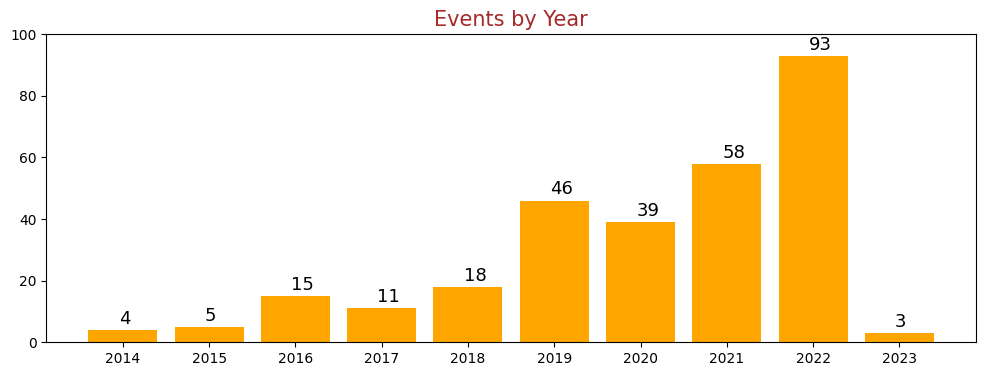

In [179]:
plt.figure(figsize = (12,4))
plt.bar(height = vc.values, x = vc.index, color = "orange")
plt.xticks(vc.index, vc.index)
for i in vc.index:
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+2), size = 13)
plt.ylim(0,100)
plt.title("Events by Year", size = 15, color = "brown")
plt.show()

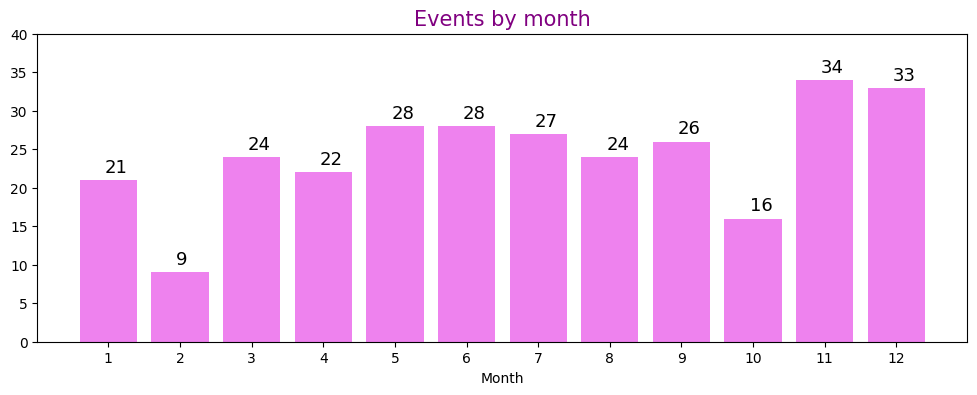

In [180]:
vc = data.event_month.value_counts()
vc = vc.sort_index()
plt.figure(figsize = (12,4))
plt.bar(height = vc.values, x = vc.index, color = "violet")
plt.xticks(vc.index, vc.index)
for i in vc.index:
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+1), size = 13)
plt.ylim(0, 5 * round(vc.max()/5) +5)
plt.xlabel("Month")
plt.title("Events by month", size = 15, color = "purple")
plt.show()

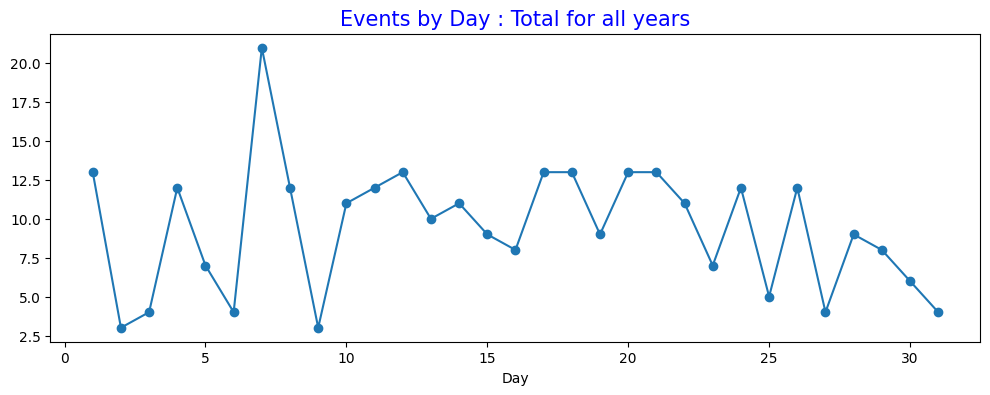

In [181]:
vc = data.event_day.value_counts()
vc = vc.sort_index()
plt.figure(figsize = (12,4))
plt.plot( vc.index, vc.values)
plt.scatter( vc.index, vc.values)
plt.xlabel("Day")
plt.title("Events by Day : Total for all years", size = 15, color = "blue")
plt.show()

# Conclusion :
- Tesla's accident volume tends to increase every year
- The number of accidents in November and December is the highest.
- Day wise no concrete info as the distribution pattern is irregular

## However for year wise pattern we should be considering the accidents vs sales data. More Tesla on road will definetly bring a rise in no. of accidents while proportion of accidents might not increase as such.

/tmp/ipython-input-25484307.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(vc[i], xy = (i-0.1, vc[i]+2), size = 10)


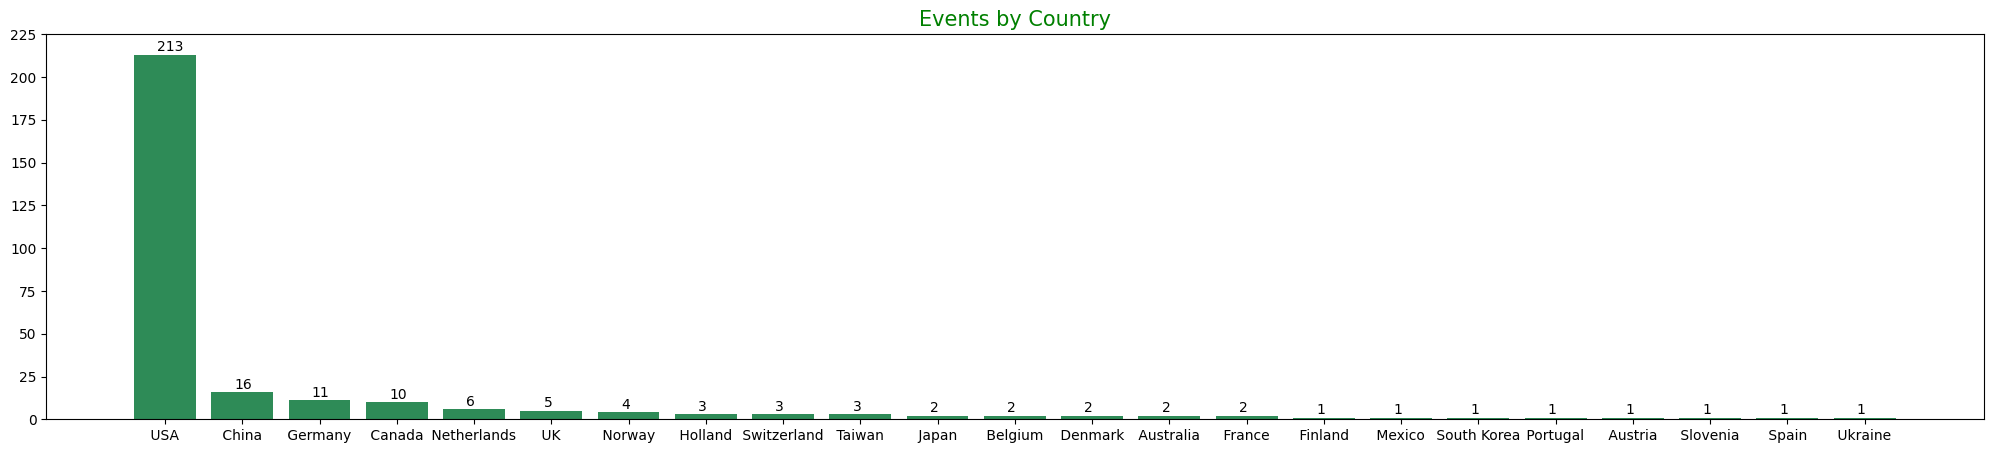

In [182]:
vc = data.Country.value_counts()
plt.figure(figsize = (25,5))
plt.bar(height = vc.values, x = vc.index, color = "seagreen")
plt.xticks(vc.index, vc.index)
for i in range(len(vc.index)):
  plt.annotate(vc[i], xy = (i-0.1, vc[i]+2), size = 10)
plt.title("Events by Country", size = 15, color = "green",)
plt.ylim(0, 25 * round(vc.max()/25))
plt.show()

In [183]:
data.State = data.State.str.strip()

/tmp/ipython-input-666643051.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(vc[i], xy = (i-0.1, vc[i]+2), size = 10)


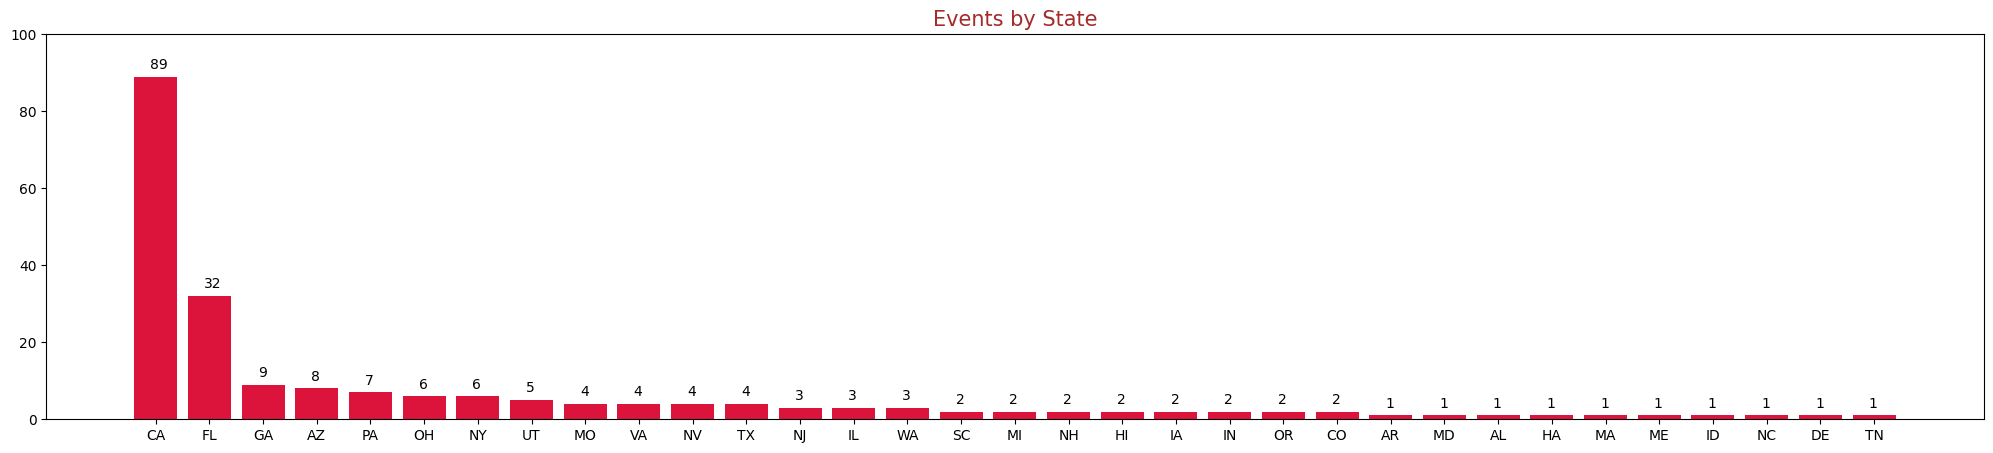

In [184]:
vc = data.State.value_counts()
vc = vc[vc.index != "-"]
plt.figure(figsize = (25,5))
plt.bar(height = vc.values, x = vc.index, color = "crimson")
plt.xticks(vc.index, vc.index)
for i in range(len(vc.index)):
  plt.annotate(vc[i], xy = (i-0.1, vc[i]+2), size = 10)
plt.title("Events by State", size = 15, color = "brown")
plt.ylim(0, 25 * round(vc.max()/25))
plt.show()

## Analyse the different aspects of the death events. For example
> 1. Compare the number of victims(deaths) in each accident.
> 2. In how many events the tesla driver died.
> 3. What is the proportion of events in which 1 or more occupants died ?
> 4. What is the distribution of events in which the vehicle hit a cyclist or a pedestrian ?
> 5. How many times did the accident involve the death of an occupant or driver of a Tesla along with a cyclist or pedestrian ?
> 6. What is the percentage of times tesla hit some other vehicle



In [185]:
data.columns

Index(['Date', 'Country', 'State', 'Description', 'Deaths', 'Tesla_Driver',
       'Tesla_Occupant', 'Other_Vehicle', 'Cyclists_Peds', 'TSLA_cycl_peds',
       'Model', 'Claimed', 'VTAD', 'event_year', 'event_month', 'event_day'],
      dtype='object')

In [186]:
col_list = ['Deaths', 'Tesla_Driver','Tesla_Occupant', 'Other_Vehicle', 'Cyclists_Peds', 'TSLA_cycl_peds']

In [187]:
color = ['salmon', 'mediumaquamarine', 'mediumpurple', 'goldenrod', 'silver', 'saddlebrown']

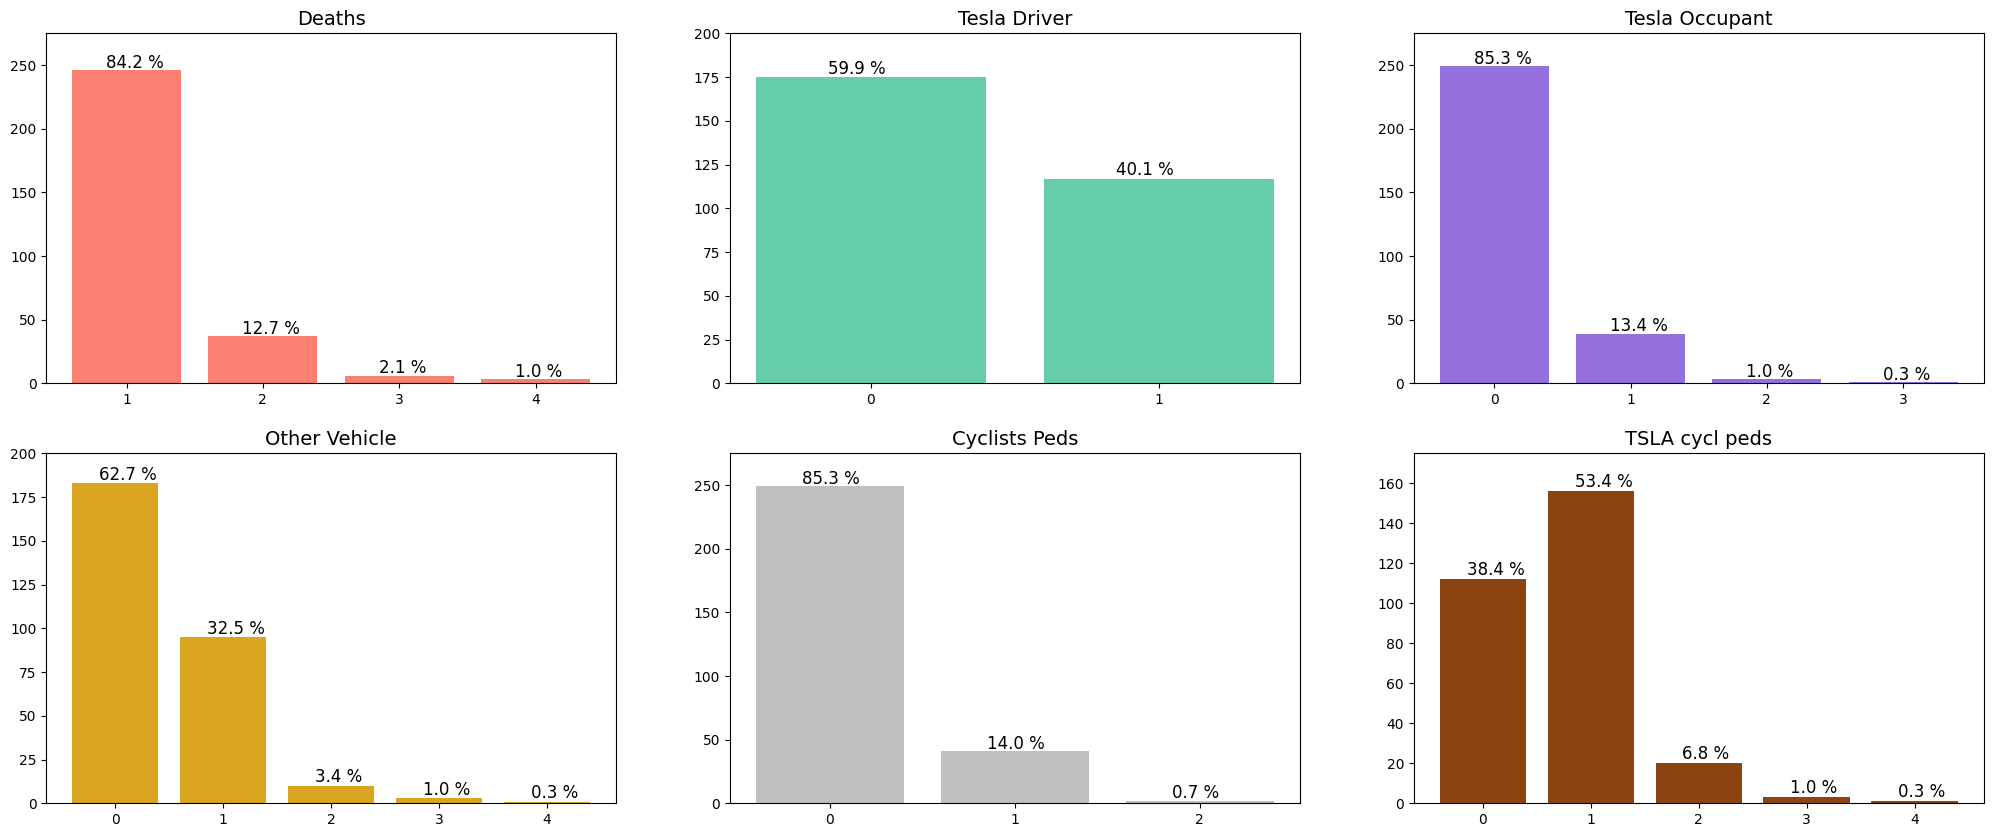

In [188]:
f,ax = plt.subplots(2,3, figsize = (25,10))
i,j,k = 0,0,0
for col in col_list:
  vc = data[col].value_counts()
  vc = vc.sort_index()
  perc = (vc/vc.sum()*100).round(1)
  #print(vc)
  ax[i,j].bar(x = vc.index, height = vc.values, color = color[k])
  ax[i,j].set_title(col.replace("_", " "), size = 14)
  ax[i,j].set_xticks(vc.index)
  for l in vc.index:
    #print(l)
    ax[i,j].annotate("{} %".format(perc[l]), xy = (l-0.15,vc[l]+2), size = 12)
    ax[i,j].set_ylim(0,  25 * round(vc.max()/25)+25)
  j += 1
  k += 1
  if j == 3:
    j = 0
    i += 1

## Study the event distribution across models

In [189]:
data.Model = data.Model.str.strip()
data.Model = data.Model.replace("-", "0")

Currently we have only 4 existing models S, X Y and 3 so we will analyse them

/tmp/ipython-input-2634202565.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+1))


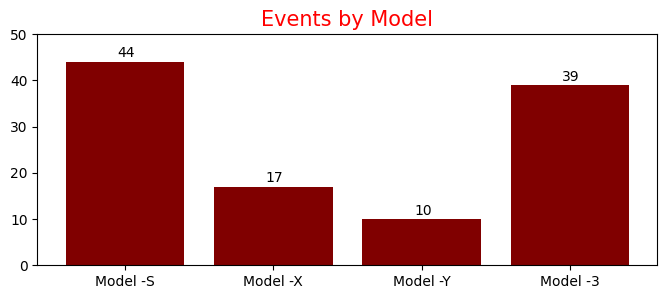

In [190]:
vc = data.Model.value_counts()
vc = vc[["S", "X", "Y", "3"]]
plt.figure(figsize = (8,3))
plt.bar(height = vc.values, x = vc.index, color = "maroon")
plt.xticks(vc.index, "Model -"+ vc.index.astype(str))
for i in range(len(vc.index)):
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+1))
plt.title("Events by Model", size = 15, color = "red")
plt.ylim(0, 25 * round(vc.max()/25))
plt.show()

# Check the distribution of Verified Tesla autopilot deaths.

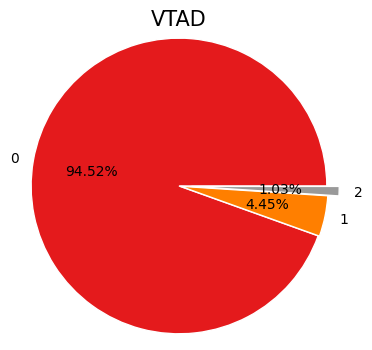

In [191]:
vc = data.VTAD.value_counts()
plt.figure(figsize = (8,4))
vc.plot.pie(radius = 1.2, autopct = "%1.2f%%",  wedgeprops = {'edgecolor':"white"}, cmap = 'Set1',
            explode = [0.001, 0.01,0.1])
plt.ylabel("")
plt.title("VTAD", pad = 5, size = 15)
plt.show()